# MNIST Uncertainty

In [17]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()

COLORS = sns.color_palette()

import torch
from torch import nn
import torch.nn.functional as f
from torchvision import datasets, transforms
from torch.utils.data import Dataset

from utils import flat_to_triangular, make_cholesky, plot, clean_curr_axes, onehot, log_sum_exp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

np.random.seed(3)

batch_size = 128
test_batch_size = 128
n_max_train = 600
rotation = 0
transform = transforms.Compose([
                        transforms.RandomRotation([rotation,rotation], resample=False, expand=False, center=None),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

class SubMNIST(datasets.MNIST):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        idx = list(range(super().__len__()))
        self.idx = np.random.choice(idx, size=n_max_train, replace=False)
            
    def __len__(self):
        return len(self.idx)
    
    def __getitem__(self, index):
        idx = self.idx[index]
        return super().__getitem__(idx)
            
    
if n_max_train is not None:
    train_cls = SubMNIST
else:
    train_cls = datasets.MNIST
    
train_dataset = train_cls('data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True,transform=transform)

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=test_batch_size, shuffle=True, **kwargs)

n_classes = 10
print(len(train_loader.dataset))

600


In [9]:
class FeaturesExtractor(nn.Module):
    def __init__(self, n_out, dropout=0):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=2), nn.Dropout2d(dropout), nn.LeakyReLU(),
            nn.Conv2d(16, 32, 5, stride=2), nn.Dropout2d(dropout), nn.LeakyReLU(),
        )
        self.fcs = nn.Sequential(
            nn.Linear(4*4*32, 128), nn.Dropout(dropout), nn.LeakyReLU(),
            nn.Linear(128, n_out), nn.Dropout(dropout), nn.LeakyReLU(),
        )
        
    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        return self.fcs(x)
    
    
class CovarianceStochasticLayer(nn.Module):
    def __init__(self, deterministic=False):
        super().__init__()
        self.deterministic = deterministic

    def forward(self, mu_q, cholesky):
        if self.deterministic:
            return mu_q
        else:
            eps = torch.randn_like(mu_q)
            return mu_q + eps @ cholesky
    
    def forward_diagonal(self, mu_q, logvar_q):
        eps = torch.randn_like(mu_q)
        std = (logvar_q/2).exp()
        return mu_q + std * eps

    def get_kl(self, mu_q, L_logdiag_q, L_q):
        if not self.deterministic:
            kl = -0.5 * (1 + L_logdiag_q - mu_q.pow(2) - torch.diag(L_q @ L_q.permute(1, 0)))
            #print(L_logdiag_q.sum().item(), mu_q.pow(2).sum().item(), torch.diag(L_q @ L_q.permute(1, 0)).sum().item())
            return kl.sum()
        else:
            return 0.

class BayesianClassifier(nn.Module):
    def __init__(self, n_classes, last_layer_size, deterministic=False, dropout=0):
        super().__init__()
        self.features = FeaturesExtractor(n_out=last_layer_size, dropout=dropout)
        self.stochastic = CovarianceStochasticLayer(deterministic)
        
        self.n_classes = n_classes
        self.last_layer_size = last_layer_size
        self.a_shape = (last_layer_size, n_classes)  # shape of stochastic weight matrix
        self.a_size = np.prod(self.a_shape)
        self.b_size = n_classes
        n_parameters = self.a_size + self.b_size
        
        self.mu_ab = nn.Parameter(torch.zeros((n_parameters)))
        self.logvar_ab = nn.Parameter(-3 * torch.ones((n_parameters)))
        self.cov_ab_params = nn.Parameter(torch.zeros((n_parameters*(n_parameters-1)//2)).normal_() * 0.01)
        
    def forward(self, x, t, n_samples=1):
        mu_ab = self.mu_ab
        logvar_ab = self.logvar_ab
        cov_ab_params = self.cov_ab_params
        batch_size = x.size(0)
        h = self.features(x)
        cov_ab = flat_to_triangular(cov_ab_params)

        # sample n_samples times a and b
        mu = self.mu_ab.unsqueeze(0).expand(n_samples, -1)
        L = make_cholesky(logvar_ab, cov_ab)
        ab_sample = self.stochastic(mu, L) 
        a, b = ab_sample[:, :-self.b_size], ab_sample[:, -self.b_size:]

        # reshape into [n_samples, *]
        a = a.unsqueeze(1).view(-1, *self.a_shape)
        b = b.unsqueeze(1)

        # compute y of size [n_samples x batch_size x n_classes]
        y = h @ a + b   # stochasticity here only comes from a and b

        # extend t and flatten 
        t = t.unsqueeze(0).expand(n_samples, batch_size)
        t = t.contiguous().view(-1)
        y = y.contiguous().view(-1, self.n_classes)

        # Reconstruction loss, estimated by MC
        recons = f.cross_entropy(y, t, reduction='none')
        recons = recons.view(n_samples, batch_size)

        # Accuracy
        y = y.view(n_samples, batch_size, self.n_classes)
        t = t.view(n_samples, batch_size)
        pred_class = torch.max(y.detach(), dim=2)[1]   # tensor of indices
        acc = torch.mean((t==pred_class).float(), 0)

        # KL loss, both analytic and by MC
        kl = self.stochastic.get_kl(mu_ab, logvar_ab, L)

        # compute elbo and view as [n_samples x batch_size]
        elbo = - recons - kl 
        elbo = elbo.view(n_samples, batch_size)
        
        return {'elbo':elbo, 'accuracy':acc, 'y':y, 'nll': recons, 'kl':kl}
        

In [42]:
deterministic = False
path = f"mnist-covariance{('-deterministic' if deterministic else '')}.pt"
bayesian_model = torch.load(path)
deterministic = True
path = f"mnist-covariance{('-deterministic' if deterministic else '')}.pt"
ml_model = torch.load(path)
deterministic = False
path = f"mnist-covariance{('-deterministic' if deterministic else '')}-dropout.pt"
drop_bayesian_model = torch.load(path)
deterministic = True
path = f"mnist-covariance{('-deterministic' if deterministic else '')}-dropout.pt"
drop_ml_model = torch.load(path)

bayesian_model.train()
ml_model.train()
drop_bayesian_model.train()
drop_ml_model.train()
pass

Accuracy: Baysian 0.1739959716796875  ML  0.1953125  (dropout) Baysian 0.18611907958984375  (dropout )ML  0.3515625 

Logp: Baysian -9.83481216430664  ML  -56.841949462890625  (dropout) Baysian -3.5722742080688477  (dropout) ML  -3.5722742080688477

True 4 | Bayesian: 8 ML: 8


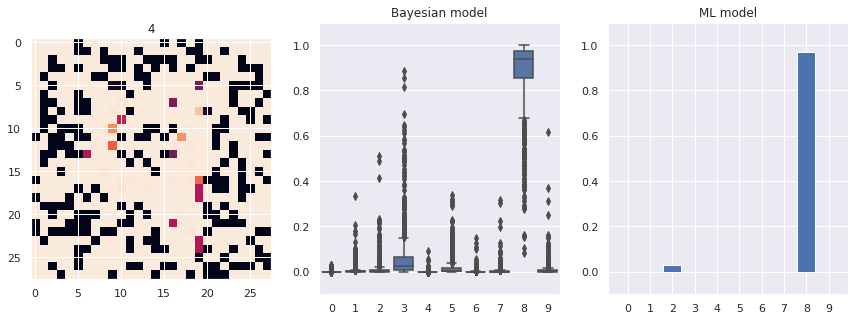

True 8 | Bayesian: 8 ML: 8


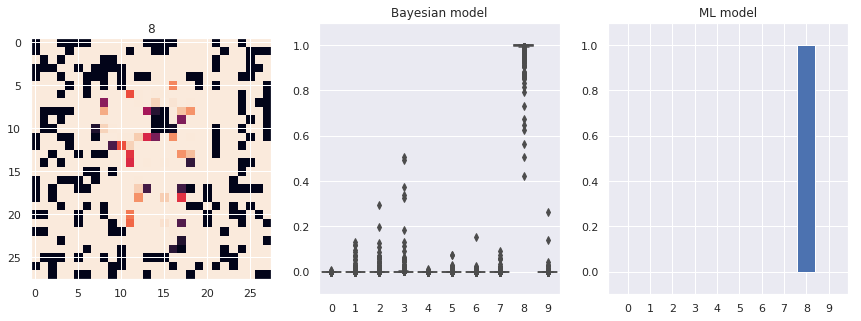

True 7 | Bayesian: 3 ML: 3


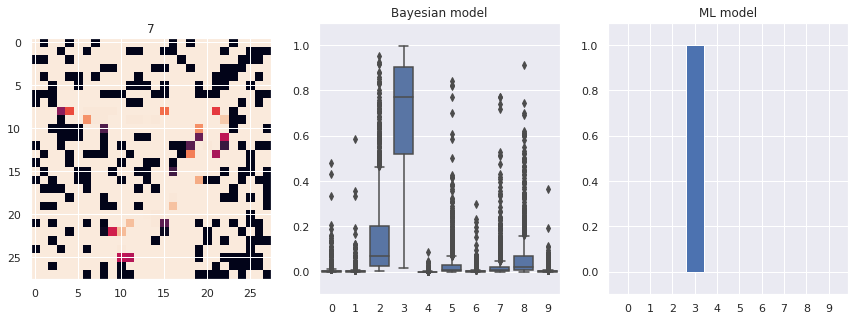

True 0 | Bayesian: 8 ML: 5


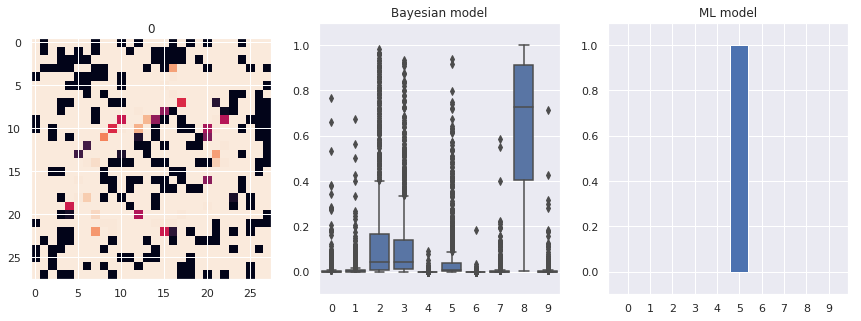

True 3 | Bayesian: Uncertain ML: 3


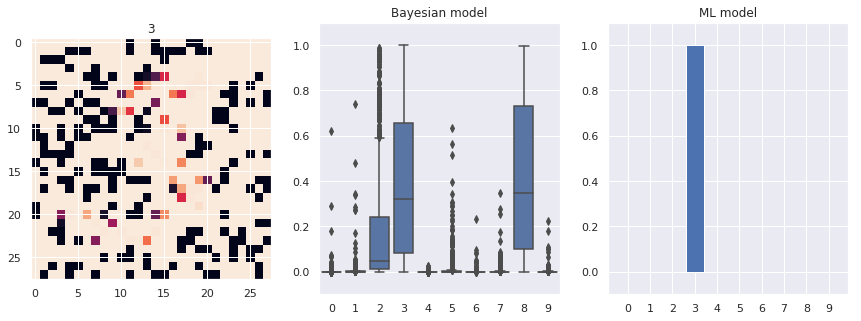

True 2 | Bayesian: 8 ML: 2


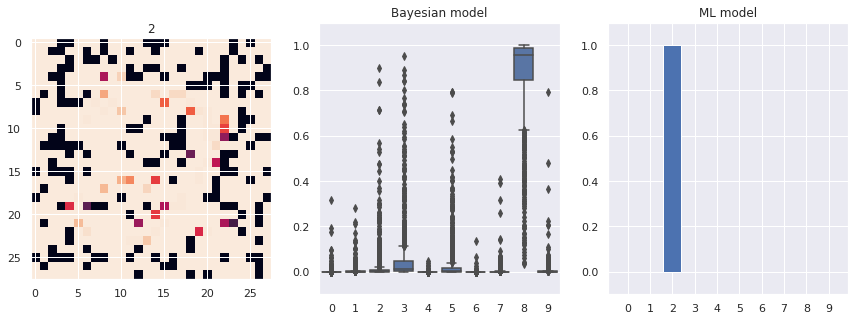

True 7 | Bayesian: Uncertain ML: 5


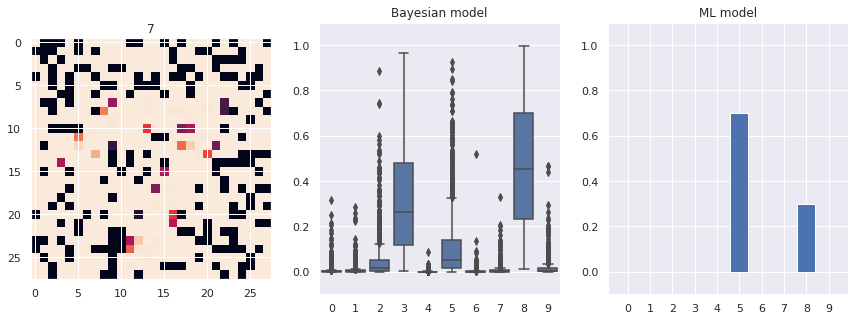

True 6 | Bayesian: 2 ML: 2


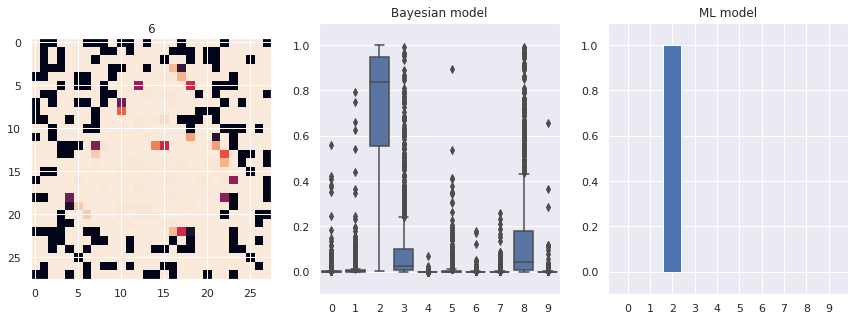

True 6 | Bayesian: 8 ML: 2


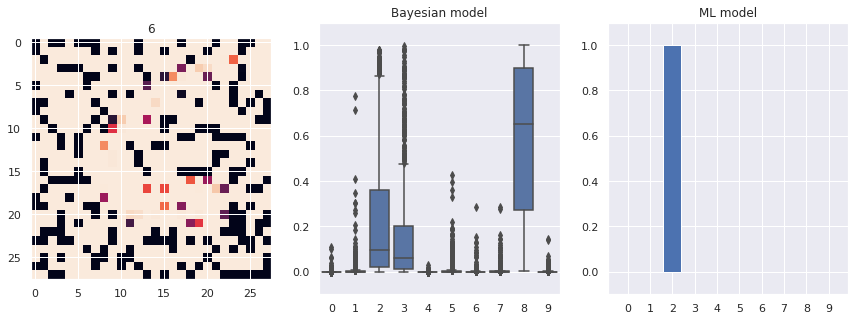

True 0 | Bayesian: Uncertain ML: 2


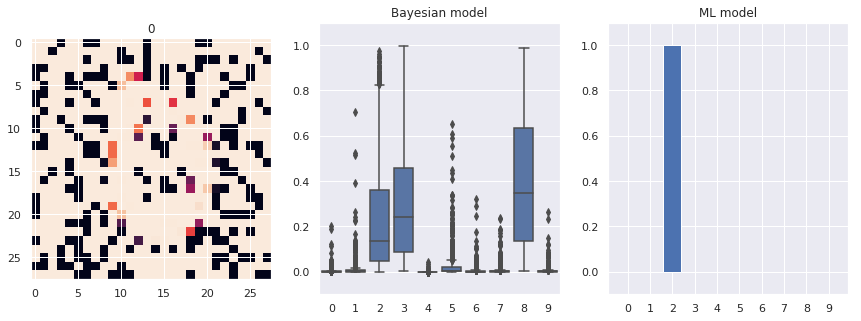

In [73]:
n_samples=1024
show_dropout = False
binary_noise = 0.7
normal_noise = 0
full_noise = False

x,t = next(iter(test_loader))

x = x.to(device)
t = t.to(device)

# process output
if normal_noise:
    noise = x.clone().normal_(0, normal_noise)
    x = x + noise
if binary_noise:
    noise = x.clone().uniform_()
    x[noise<binary_noise] = x.max()
if full_noise:
    x = x.normal_()
    
def decision(probs):
    return np.argmax(probs) if np.max(probs) > 0.7 else 'Uncertain'

#x.normal_()

# process input
bayesian_output = bayesian_model(x,t, n_samples=n_samples)
ml_output = ml_model(x,t, n_samples=n_samples)
drop_bayesian_output = drop_bayesian_model(x,t, n_samples=n_samples)
drop_ml_output = drop_ml_model(x,t, n_samples=n_samples)

print(f"Accuracy: Baysian {bayesian_output['accuracy'].mean().item()}  ML  {ml_output['accuracy'].mean().item()}  (dropout) Baysian {drop_bayesian_output['accuracy'].mean().item()}  (dropout )ML  {drop_ml_output['accuracy'].mean().item()} \n")
bayesian_logp =  - log_sum_exp(bayesian_output['nll'], dim=0, sum_op=torch.mean).mean().item()
ml_logp =  - log_sum_exp(ml_output['nll'], dim=0, sum_op=torch.mean).mean().item()
drop_bayesian_logp =  - log_sum_exp(drop_bayesian_output['nll'], dim=0, sum_op=torch.mean).mean().item()
drop_ml_logp =  - log_sum_exp(drop_bayesian_output['nll'], dim=0, sum_op=torch.mean).mean().item()
print(f"Logp: Baysian {bayesian_logp}  ML  {ml_logp}  (dropout) Baysian {drop_bayesian_logp}  (dropout) ML  {drop_ml_logp}\n")

for k in range(10):
    plt.figure(figsize=(25, 5))
    plt.subplot(1,5,1)
    plt.title(f"{t[k]}")
    d = x[k].cpu().data.numpy().squeeze()
    plt.imshow(d)
      
    plt.subplot(1,5,2)
    plt.ylim([-0.1,1.1])
    y = f.softmax(bayesian_output.get('y'),-1).cpu().data.numpy()[:,k]
    #y = bayesian_output.get('y').cpu().data.numpy()
    classes = list(range(10))
    bayes_probs = np.median(y,0)
    bayes_probs = bayes_probs / bayes_probs.sum()
    stds = np.std(y,0)[k]
    ci = np.percentile(y,[5,95],axis=0)
    #low_bayes_probs = np.percentile(y,5,axis=0)
    sns.boxplot(data=y, color=sns.color_palette()[0])
    #plt.bar(classes, bayes_probs, yerr=ci)
    plt.xticks(classes, classes)
    plt.title('Bayesian model')
      
    plt.subplot(1,5,3)
    plt.ylim([-0.1,1.1])
    ml_probs = f.softmax(ml_output.get('y').mean(0),-1).cpu().data.numpy()[k]
    #y = ml_output.get('y').mean(0),-1).cpu().data.numpy()
    classes = list(range(10))
    plt.bar(classes, ml_probs)
    plt.xticks(classes, classes)
    plt.title('ML model')
      
    if show_dropout:
        plt.subplot(1,5,4)
        plt.ylim([-0.1,1.1])
        y = f.softmax(drop_bayesian_output.get('y'),-1).cpu().data.numpy()[:,k]
        #y = bayesian_output.get('y').cpu().data.numpy()
        classes = list(range(10))
        drop_bayes_probs = np.median(y,0)
        drop_bayes_probs = drop_bayes_probs / drop_bayes_probs.sum()
        stds = np.std(y,0)[k]
        ci = np.percentile(y,[5,95],axis=0)
        #low_bayes_probs = np.percentile(y,5,axis=0)
        sns.boxplot(data=y, color=sns.color_palette()[0])
        #plt.bar(classes, bayes_probs, yerr=ci)
        plt.xticks(classes, classes)
        plt.title('(dropout) Bayesian model')

        plt.subplot(1,5,5)
        plt.ylim([-0.1,1.1])
        y = f.softmax(drop_ml_output.get('y'),-1).cpu().data.numpy()[:,k]
        #y = bayesian_output.get('y').cpu().data.numpy()
        classes = list(range(10))
        drop_ml_probs = np.median(y,0)
        drop_ml_probs = drop_ml_probs / drop_ml_probs.sum()
        stds = np.std(y,0)[k]
        ci = np.percentile(y,[5,95],axis=0)
        #low_bayes_probs = np.percentile(y,5,axis=0)
        sns.boxplot(data=y, color=sns.color_palette()[0])
        #plt.bar(classes, bayes_probs, yerr=ci)
        plt.xticks(classes, classes)
        plt.title('(dropout ) ML model')
    
    print(f"True {t[k]} | Bayesian: {decision(bayes_probs)} ML: {decision(ml_probs)}")
    if show_dropout:
        print(" (dropout) Bayesian: {decision(drop_bayes_probs)} ML: (dropout)  {decision(drop_ml_probs)}")
      
    plt.show()

## Likelihood Vs. Noise

In [66]:
n_samples = 10
data = []
from collections import defaultdict

models = {'Bayes': bayesian_model, 'ML': ml_model} #, '(dropout) Bayes' : drop_bayesian_model, '(dropout) ML' :drop_ml_model}
logp = {}
h = {}
for epsilon in np.linspace(0,1,10):
    entropies = defaultdict(lambda : 0.)
    idx = 0
    reconss = defaultdict(list)
    y = defaultdict(list)
    acc = defaultdict(list)
    for x,t in test_loader:
        x = x.to(device)
        t = t.to(device)
        
        noise = x.clone().uniform_()
        x[noise<epsilon] = x.max()
        
        for k,model in models.items():

            output = model(x,t, n_samples=n_samples)

            reconss[k] += [output.get('nll')]
            y[k] += [output.get('y')]
            acc[k] = [output.get('accuracy')]
        
        idx += 1
        if False: #idx > 3:
            break
            
    for k,model in models.items():
        reconss[k] = torch.cat(reconss[k], 1)

        logp[k] = - log_sum_exp(reconss[k], dim=0, sum_op=torch.mean).mean().item()

        y[k] = torch.mean(torch.cat(y[k], 1), dim=0)
        #y[k] /= y[k].sum()

        h[k] = - torch.sum( f.softmax(y[k],-1) * f.log_softmax(y[k], -1),  1).mean().item()

        acc[k] = torch.cat(acc[k], 0).mean().item()
    
        
        d = {'model':k, 'logp':logp[k], 'h':h[k], 'acc':acc[k], 'noise':epsilon}
        data += [d]
    
df = pd.DataFrame(data)

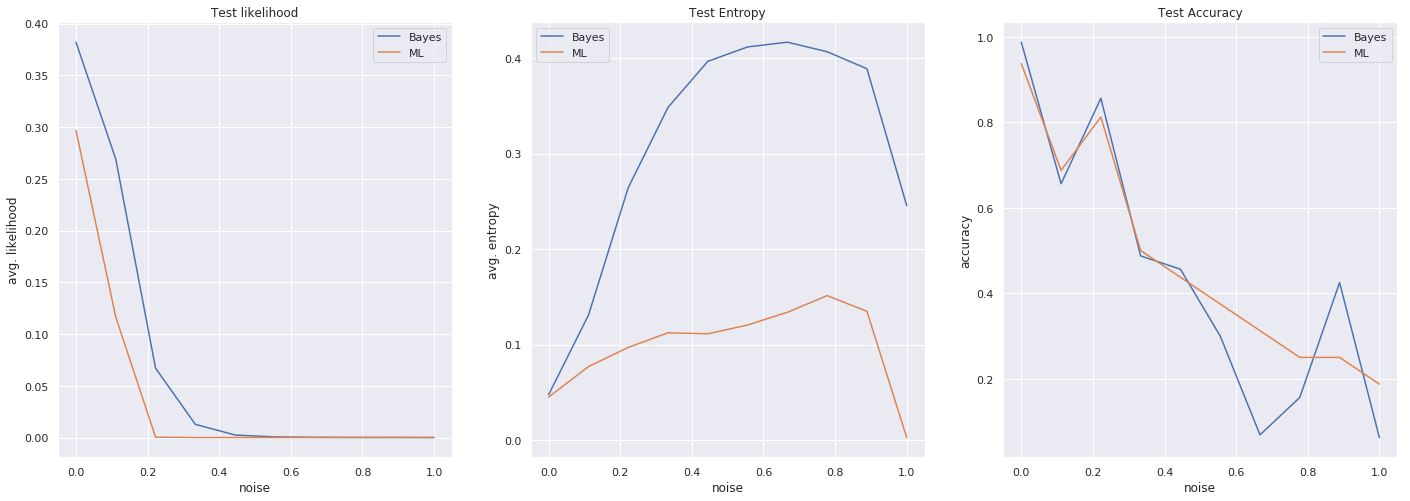

In [67]:
plt.figure(figsize=(24, 8))
plt.subplot(1,3,1)

for k in models.keys():
    color = COLORS[0] if 'Bayes' in k else COLORS[1]
    linestyle = '--' if 'dropout' in k else '-'
    ddf = df[df['model']==k]
    plt.plot(ddf['noise'], np.exp(ddf['logp']), label=k, color=color, linestyle=linestyle)
plt.legend()
plt.title('Test likelihood')
plt.xlabel('noise')
plt.ylabel('avg. likelihood')

plt.subplot(1,3,2)
for k in models.keys():
    ddf = df[df['model']==k]
    color = COLORS[0] if 'Bayes' in k else COLORS[1]
    linestyle = '--' if 'dropout' in k else '-'
    plt.plot(ddf['noise'], ddf['h'], label=k, color=color, linestyle=linestyle)
plt.legend()
plt.title('Test Entropy')
plt.xlabel('noise')
plt.ylabel('avg. entropy')

plt.subplot(1,3,3)
for k in models.keys():
    ddf = df[df['model']==k]
    color = COLORS[0] if 'Bayes' in k else COLORS[1]
    linestyle = '--' if 'dropout' in k else '-'
    plt.plot(ddf['noise'], ddf['acc'], label=k, color=color, linestyle=linestyle)
plt.legend()
plt.title('Test Accuracy')
plt.xlabel('noise')
plt.ylabel('accuracy')
plt.show()

# Posterior Stats

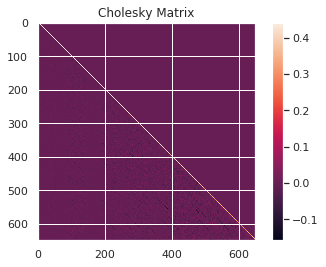

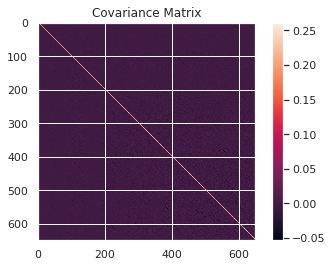

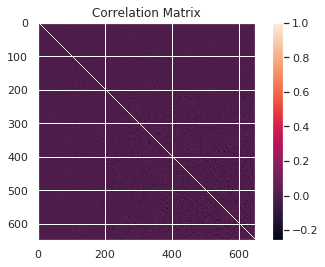

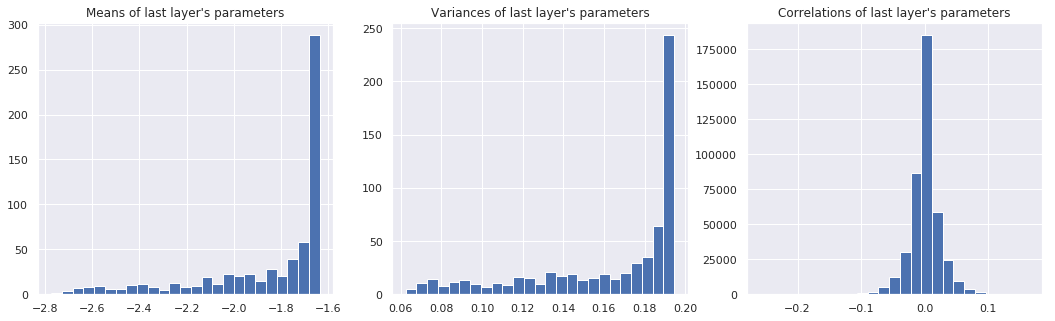

In [304]:
mu_ab = bayesian_model.logvar_ab
logvar_ab = bayesian_model.logvar_ab
cov_ab_params = bayesian_model.cov_ab_params
cov_ab = flat_to_triangular(cov_ab_params)

L = make_cholesky(logvar_ab, cov_ab)

mu_ab = mu_ab.detach().cpu().numpy()
logvar_ab = logvar_ab.detach().cpu().numpy()
L = L.detach().cpu().numpy()
cov_ab = cov_ab.detach().cpu().numpy()


Cov = L @ L.T
inv_stds = np.diag(np.diag(Cov)**(-0.5))
Corr = inv_stds @ Cov @ inv_stds


plt.title("Cholesky Matrix")
plt.imshow(L)
plt.colorbar()
plt.show()

plt.title("Covariance Matrix")
plt.imshow(Cov)
plt.colorbar()
plt.show()

plt.title("Correlation Matrix")
plt.imshow(Corr)
plt.colorbar()
plt.show()

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.title("Means of last layer's parameters")
plt.hist(mu_ab, bins=25)
plt.subplot(1, 3, 2)
plt.title("Variances of last layer's parameters")
plt.hist(np.exp(logvar_ab), bins=25)
plt.subplot(1, 3, 3)
plt.title("Correlations of last layer's parameters")  # corr coefficients between pairs of DIFFERENT variables
correlations = Corr[~np.eye(Corr.shape[0], dtype=bool)]
plt.hist(correlations, bins=25)
plt.show()

In [380]:
np.exp(-0.6)

0.5488116360940264